In [100]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 1
Due March 12, 2019.

For the midterm project, you will develop a Tolman-Oppenheimer-Volkov (TOV) solver to compute the hydrostatic structure of a relativistic neutron star. You will use this to determine the maximum masses of cold neutron stars (NSs) for several different equations of state (EOS).

Your code should adhere to the course Coding Standards.

  - Write a numerical solver for the spherically-symmetric TOV equations using a fourth-order Runge-Kutta integrator. Assume a polytropic EOS specified by $K$ and $\gamma$. You may find these notes particularly helpful.
  
\begin{align}
\frac{dm}{dr} &= 4\pi r^2 \rho \\
\frac{dP}{dr} &= -\frac{\rho m }{r^2}\left ( 1 + \frac{P}{\rho}\right ) \left( 1 + \frac{4\pi P^3}{m} \right ) \left ( 1 - \frac{2m}{r}\right ) ^{-1}\\
\frac{d\Phi}{dr} &= - \frac{1}{\rho} \frac{dP}{dr}\left( 1 + \frac{P}{\rho}\right ) ^{-1}
\end{align}

For a polytropic eos: $P = K \rho_0^\Gamma$, where $K$ is the polytropic gas constant and $n$ defined by $\Gamma \equiv 1 + 1/n$ is the polytropic index. We then have   $\rho = \rho_0 + P/(\Gamma -1 )$  and $\rho_0 \epsilon = P/(\Gamma -1 )$.
   
Below, constants are the corresponding barred ones.

In [101]:
from tov import *

2.4375144350725285e-31
7.807083010105192e-31
6.626073140304381e-31
5.55681772004342e-31
4.4693911015970774e-30
9.297197991787412e-31
1.2918647993780986e-30
2.652955717257455e-31
1.9723359166873597e-30
2.7617361023090995e-30
0.16151886459991324


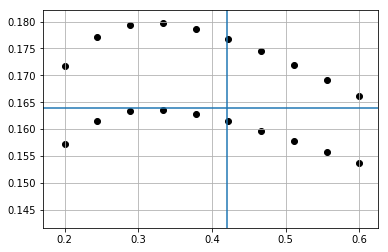

In [113]:
test_star = PolytropeStar(gamma = 2)
integrator = 'dopri5'

for rhoc_bar in np.linspace(0.2, 0.6, 10):
    test_star.set_initial_conditions(rhoc = rhoc_bar)
    solver =  test_star.solve_star(integrator = integrator)
    print(solver.y[1][-1])
    plt.scatter(rhoc_bar, solver.y[0][-1], c='k')
    plt.scatter(rhoc_bar, solver.y[3][-1], c='k')
solver = test_star.set_initial_conditions(rhoc = 0.420).solve_star(
                    integrator = integrator)
print(solver.y[0][-1])
plt.axvline(0.42)
plt.axhline(0.164)
plt.grid()

In [4]:
n = 4/7
gamma = 1+1/n
print(gamma)

K = 30000 # in c = G = M_sun = 1

2.75


    
  - Determine the maximum mass of a cold NS for $K=30000$ (in $G=c=M_\odot=1$ units) and $\gamma=2.75$.
 

In [5]:
gamma = 2.75
n = 1/(gamma - 1)

values = []

N = 200
for rhoc_bar in np.linspace(0.1, 1.8, N):
    test_star = PolytropeStar(gamma).set_initial_conditions(rhoc = rhoc_bar)
    solver = test_star.solve_star()

    r = solver.t
    M, P, Phi, M0 = solver.y
    values.append([r[-1], M[-1], P[-1], Phi[-1], M0[-1], rhoc_bar])
   

<IPython.core.display.Math object>


Maximum values for K = 30000, \gamma = 2.75:
     M_bar = 0.042
     R     = 950.9  km
     M     = 0.801 M_sun   
     M_0   = 0.537 M_sun     
     rho_c = 3.028e+15 g/cc      



Text(0.5,0,'Central density [g/cc]')

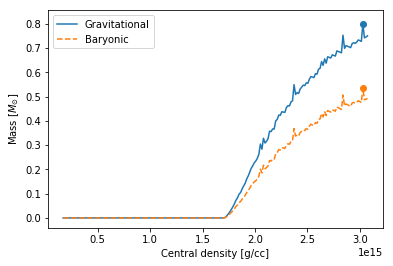

In [6]:
K     = 30000      # C = G = M_sun = 1
K_cgs = 1.98183e-6 # cgs
 
radius, grav_mass, pressure, _, mass, rhoc_bar = np.array(values).T
imax = np.argmax(grav_mass)

M_max_sun = grav_mass[imax] * K**(n/2)

length_conv  = 6.7706e-6
density_conv = 1.6199e-18
rhoc_cgs = rhoc_bar * K**(-n)/density_conv
r_km     = radius * K**(n/2)/length_conv * 1e-5

from IPython.display import display, Latex, Math
display(Math("Ax=b"))

disp_string = r"""
Maximum values for K = 30000, \gamma = 2.75:
     M_bar = {mbar:.3f}
     R     = {r:.4g}  km
     M     = {gm:.3f} M_sun   
     M_0   = {bm:.3f} M_sun     
     rho_c = {cd:.4g} g/cc      
""".format(mbar = grav_mass[imax], r =  r_km[imax],
           gm =  grav_mass[imax] * K**(n/2),
           bm =  mass[imax] * K**(n/2), cd =  rhoc_cgs[imax])

print(disp_string)

plt.scatter(rhoc_cgs[imax], grav_mass[imax] * K**(n/2), c = 'C0')
plt.scatter(rhoc_cgs[imax], mass[imax]* K**(n/2), c = 'C1')

plt.plot(rhoc_cgs, grav_mass* K**(n/2), '-', label = 'Gravitational')
plt.plot(rhoc_cgs, mass* K**(n/2), '--', label = 'Baryonic')
plt.legend()
plt.ylabel('Mass [$M_{\odot}$]')
plt.xlabel('Central density [g/cc]')

 
  - Now, modify your code to use any arbitrary table-based EOS. Specifically, make your solver compatible with the EOS available on stellarcollapse.org. There is example code on that site in C++ and Fortran for reading and using the tables there, and working with the EOS tables is trivial in Python using h5py.
 

Loading the HShen, there are some weird things with the temperature ranges of this one

In [7]:
import h5py

test = 'HShen_HyperonEOS_rho220_temp180_ye65_version_1.1_20131007.h5'
ftest = h5py.File(test)
print(list(ftest.keys()))


['Abar', 'Meff', 'Xa', 'Xh', 'Xn', 'Xp', 'Zbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'timestamp', 'ye']


/home/halvard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def get_bounds(x):
    return [np.min(x), np.max(x)]

In [9]:
print('log', get_bounds(ftest['logrho'][:]),   'g/cm^3')
print('log', get_bounds(ftest['logpress'][:]), 'MeV/fm^3')
print('log', get_bounds(ftest['ye'][:]))

log [3.0, 16.0] g/cm^3
log [18.573418605725163, 37.161923489191174] MeV/fm^3
log [0.01, 0.65]


There are 
Table structures:
 - Temperature  
$T$[MeV]$: -1.0\leq \log_{10}(T) \leq 2.6$; mesh of $\log_{10}(T) = 0.04$
 - Proton fraction  
$Y_p: 0.01 \leq Y_p \leq 0.65$; mesh of $Y_p= 0.01$
 - Baryon mass density   
$\rho_B$[g/cm3]$: 5.1 \leq \log_{10}(\rho_B) \leq 16.0$; mesh of $\log_{10}(\rho_B) = 0.1$

In [10]:
filename = 'Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5'

In [11]:
f = h5py.File(filename, 'r')
keys = list(f.keys())
print(keys)

['Abar', 'X3he', 'X4li', 'Xa', 'Xd', 'Xh', 'Xn', 'Xp', 'Xt', 'Zbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'timestamp', 'ye']


# Figuring out the units

In [12]:
print('log', get_bounds(f['logrho'][:]),   'g/cm^3')
print('log', get_bounds(f['logpress'][:]), 'MeV/fm^3')
# print(get_bounds(f['log'][:]))

log [2.2202492, 15.500249] g/cm^3
log [18.012309853651733, 36.70818475697236] MeV/fm^3


In [13]:
g_cm3 = 1.6199e-18
g_cm3

1.6199e-18

In [14]:
from scipy.constants import erg, eV
5.5953e-55 * erg / eV * 1e-6 # MeV
a = 1 # MeV 
a * 1e6 * eV / erg #* 5.5953e-55 # correct units

1.6021766208000002e-06

In [15]:
MeVfm3 = 1.6021766e33 # dyne/cm2
MeVfm3 = 1.6021766e33 * 1.8063e-39
dyne_cm2 = 1
# dyne_cm2_to_cgmsun = 1.8063e-39 * 1/1.6022e33
dyne_cm2 * 1.8063e-39

1.8063e-39

In [16]:
from scipy.interpolate import (interp1d, interp2d, 
                               griddata, BivariateSpline, 
                               LinearNDInterpolator)
from scipy import optimize

class TableStar(BaseStar):
    def __init__(self, tablefile, scaling = {}, *args, **kwargs):
        """Assumes cold star, i.e minimal T. 
        
        Scales to geometrized units c = G = M_sun = 1
        
        TODO:
        convert the following from log to linear:
            rho, pres, energy, munu?, 
        """
        BaseStar.__init__(self, *args, **kwargs)
        self._allow_negative_pressure = False

        f = h5py.File(tablefile, 'r')
        self.file = f
        
        self.scaling = {}
        
        # default scaling is  c = G = M_sun = 1
        default_scaling = {'pres'  : 1.8063e-39, # from dyn/cm^2
                           'rho'   : 1.6199e-18, # from g/cm^3
                           'energy': 1.11265005605e-21,  # from erg/g
                           'munu'  : 8.96465885e-61 # from MeV
                           # munu should be MeV/baryon
                          }
        default_scaling.update(scaling)
        self.update_scaling(default_scaling)
        
        # self.T_ind = 0
        self.ye_arr   = f['ye'][:] 
        self.rho_arr  = f['logrho'][:] + np.log10(self.scaling['rho'])
        # temp_arr = f['logtemp'][:]
        
        self.energy_shift  = f['energy_shift'][0] * self.scaling['energy']

        rho_grid, ye_grid  = np.meshgrid(self.rho_arr, self.ye_arr)
        pres_values   = f['logpress'][:,0,:]  + np.log10(self.scaling['pres'])
        munu_values   = f['munu'][:,0,:]      *          self.scaling['energy']
        energy_values = f['logenergy'][:,0,:] + np.log10(self.scaling['energy'])
        
        self.ye_bounds   = (np.min(self.ye_arr),  np.max(self.ye_arr))
        self.rho_bounds  = (np.min(self.rho_arr), np.max(self.rho_arr))
        self.pres_bounds = (np.min(pres_values),  np.max(pres_values))
        

        ye_pres_points = np.column_stack([ye_grid.ravel(), pres_values.ravel()]),
        ye_rho_points  = np.column_stack([ye_grid.ravel(), rho_grid.ravel()]),
        
            
        self.rho_interp       = LinearNDInterpolator(ye_pres_points, rho_grid.ravel(), )
                                                     #fill_value = np.inf)
        self.pres_interp      = LinearNDInterpolator(ye_rho_points, pres_values.ravel(),)
                                                    #fill_value = np.inf)
        self.energy_interp    = LinearNDInterpolator(ye_rho_points, energy_values.ravel(),)
                                                    #fill_value = np.inf)
        self.munu_interp_rho  = LinearNDInterpolator(ye_rho_points, munu_values.ravel(),)
                                                    #fill_value = np.inf)
        self.munu_interp_pres = LinearNDInterpolator(ye_pres_points, munu_values.ravel(),)
                                                    #fill_value = np.inf)
        
        # self.rho_interp_lin_scaled = lambda points: rho_scale*10**self.rho_interp(points)
        
    def update_scaling(self, new_scaling):
        """update scaling constant dict.
        
        Original units:
        rho:    g/cm3   
        pres:   MeV/fm3
        energy: MeV
        munu':  MeV
        """
        self.scaling.update(new_scaling) 
        
    def check_in_bounds(self, val, val_type):
        if val_type == 'rho':
            bounds = self.rho_bounds
        elif val_type == 'pres':
            bounds = self.pres_bounds
        elif val_type == 'ye':
            bounds = self.ye_bounds
        else:
            raise ValueError('Invalid val_type, %s' %val_type)
        if not ((val < bounds[1]) and (val > bounds[0])):
            raise ValueError("Value '%s' out of bounds. %.3f not in interval [%.3f, %.2f]" % (val_type, val, bounds[0], bounds[1]))
        
        
    def energy(self, ye, rho):
        logrho = np.log10(rho)
        return 10**self.energy_interp(ye, logrho) - self.energy_shift
    
        
    def munu(self, ye, val, val_type):
        """Returns value of munu either from pressure or from density, based on val_type argument"""
        self.check_in_bounds(val, val_type)
        if val_type == 'rho':
            return self.munu_interp_rho([ye, val])[0]
        elif val_type == 'pres':
            return self.munu_interp_pres([ye, val])[0]
        else:
            raise ValueError("val_type must be either 'rho' or 'pres'")
        
    def P(self, rho):
        a, b = self.ye_bounds
        logrho = np.log10(rho)
        res = optimize.bisect(self.munu, a = a, b = b, args=(logrho, 'rho'), )
                                   #method = 'brentq', bracket = self.ye_bounds)
        self.current_ye = res
        return 10**self.pres_interp(self.current_ye, logrho)
    
    def rho(self, P):
        a, b = self.ye_bounds
        logP = np.log10(P)
        res = optimize.bisect(self.munu, a = a, b = b,  args=(logP, 'pres'), )
                                   #method = 'brentq',bracket = self.ye_bounds)
        self.current_ye = res
        return 10**self.rho_interp(self.current_ye, logP)
    
    def rho0(self, P, rho = None):
        """Uses P as is, no convert to log"""
        rho = rho or self.rho(P)
        eps = self.energy(self.current_ye, rho)
        return rho / (1 + eps)
    
    def get_pressure_event(self):
        """Passed to solver for termination when is pressure 0."""
        def pressure_event(t, y):
            print(y)
            if np.isnan(y[1]):
                return -1
            else:
                return y[1] # - 10**self.pres_bounds[0]
        pressure_event.terminal = True
        return pressure_event



In [17]:
print(filename)

Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5


initiating
solving 0.7236599922180176
time use:  13.30276370048523
initiating
solving 0.6942379474639893


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/home/halvard/uio/PHY905_NumericalRelativity/project1/tov.py:188: UserWarning: Something went wrong in the integration, and we need a better error message
  warnings.warn('Something went wrong in the integration, and we need a better error message')


time use:  4.89069938659668
initiating
solving 0.7182941436767578
time use:  4.579551935195923
initiating
solving 0.6964097023010254
time use:  8.483421802520752


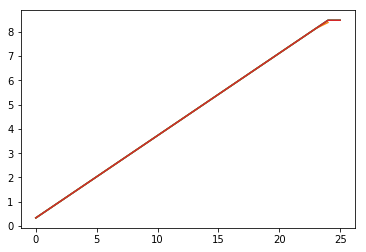

In [27]:
import time
# rhoc = 3e15 * 1.6199e-18
for integrator in ["dop853","dopri5","vode","lsoda"]:
    start1 = time.time()
    print('initiating')
    test = TableStar(filename).set_initial_conditions(rhoc = 10**-3)
    start = time.time()
    print('solving with %s', start - start1)
    solver, r_values, values = test.old_solve_star(Nr = 100, integrator = integrator)
    stop = time.time()
    print('time use: ', stop - start)

    plt.plot(r_values)#, solver.y[1])

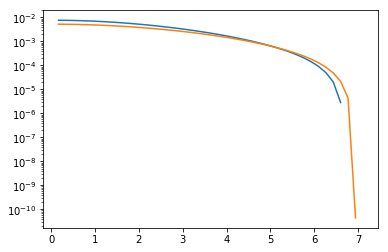

initiating
solving with 0.005 0.7070152759552002
1 0.007645922462304499 False
2 0.00762472727214487 False
1 0.00762472727214487 False
2 0.007561543970466916 False
1 0.007561543970466916 False
2 0.007457561593113994 False
1 0.007457561593113994 False
2 0.0073147060279157424 False
1 0.0073147060279157424 False
2 0.0071355606737868275 False
1 0.0071355606737868275 False
2 0.006923263997076961 False
1 0.006923263997076961 False
2 0.006681391110301229 False
1 0.006681391110301229 False
2 0.00641382710539261 False
1 0.00641382710539261 False
2 0.006124639742173919 False
1 0.006124639742173919 False
2 0.005817959171192231 False
1 0.005817959171192231 False
2 0.005497868560637473 False
1 0.005497868560637473 False
2 0.0051683183677936895 False
1 0.0051683183677936895 False
2 0.0048335366835618905 False
1 0.0048335366835618905 False
2 0.004497346189706226 False
1 0.004497346189706226 False
2 0.004163028676476002 False
1 0.004163028676476002 False
2 0.0038334878391075673 False
1 0.00383348783910

/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))
/home/halvard/uio/PHY905_NumericalRelativity/project1/tov.py:195: UserWarning: Something went wrong in the integration, and we need a better error message
  return solver, t, y


1 0.005242934860219285 False
2 0.0052311814548109785 False
1 0.0052311814548109785 False
2 0.00519608644615899 False
1 0.00519608644615899 False
2 0.005138148191271913 False
1 0.005138148191271913 False
2 0.005058180059666263 False
1 0.005058180059666263 False
2 0.004957286680613116 False
1 0.004957286680613116 False
2 0.004836832377337643 False
1 0.004836832377337643 False
2 0.0046984034327768286 False
1 0.0046984034327768286 False
2 0.0045437658077358035 False
1 0.0045437658077358035 False
2 0.004374820668207191 False
1 0.004374820668207191 False
2 0.004193559640536892 False
1 0.004193559640536892 False
2 0.0040020211198138304 False
1 0.0040020211198138304 False
2 0.0038022496404791412 False
1 0.0038022496404791412 False
2 0.003596264481551155 False
1 0.003596264481551155 False
2 0.003386086972793258 False
1 0.003386086972793258 False
2 0.0031736744440264576 False
1 0.0031736744440264576 False
2 0.002960791046179808 False
1 0.002960791046179808 False
2 0.0027490866064880976 False
1 0

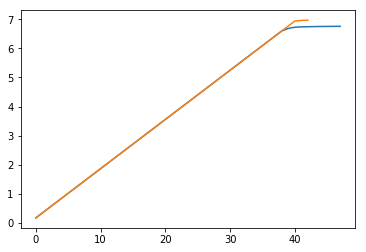

In [88]:
import time
Nr = 200
# r_max = 

start1 = time.time()
print('initiating')
rhoc = 10**-2.30
test = TableStar(filename).set_initial_conditions(rhoc = rhoc)
start = time.time()
print('solving with %.3f'%rhoc, start - start1)
solver, t1, y1 = test.old_solve_star(Nr = 200, integrator = 'vode')

rhoc = 10**-2.35
print('solving with %.3f'%rhoc, start - start1)
test.set_initial_conditions(rhoc = rhoc)
solver, t2, y2 = test.old_solve_star(Nr = 200, integrator = 'vode')
stop = time.time()
print('time use: ', stop - start)

plt.plot(t1)#, solver.y[1])
plt.plot(t2)#, solver.y[1])

In [89]:
a = [1,2,3]
a.pop()
a[-1]


2

[35, 45, 6, 7.5]

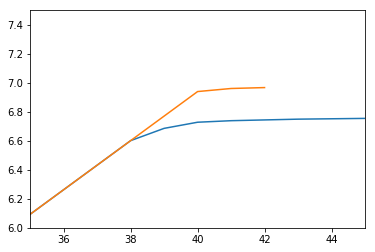

In [90]:
plt.plot(t1)#, solver.y[1])
plt.plot(t2)#, solver.y[1])
plt.axis([35,45,6,7.5])

In [ ]:
plt.semilogy(t1, y1[:, 1], label = 'pressure, $\rho_c = 10^-{2.3}$'
plt.semilogy(t2, y2[:, 1], label = 'pressure, $\rho_c = 10^-{2.35}$'
plt.axhline(10**star.pres_bounds[0], 'pressure lower bound')
plt.legend()

In [69]:
star.derivatives(t1[-1], y1[-1])

[0, 0, 0, 0]

In [71]:
y1[-1,1]

-1.8512468781723217e-15

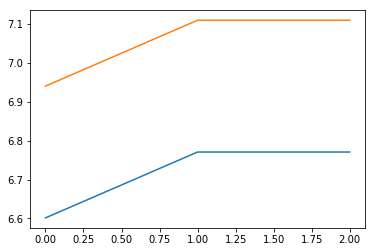

In [56]:
plt.plot(t1[-3:])
plt.plot(t2[-3:])

(-15.570262594586174, -2.290262794586173)
-3.3
-3.27939387755102
-3.2587877551020408
-3.238181632653061
-3.2175755102040813
-3.196969387755102
-3.1763632653061222
-3.1557571428571425
-3.135151020408163
-3.1145448979591834
-3.0939387755102037
-3.0733326530612244
-3.0527265306122446
-3.032120408163265
-3.0115142857142856
-2.990908163265306
-2.9703020408163265
-2.949695918367347
-2.929089795918367
-2.9084836734693873
-2.887877551020408
-2.8672714285714282
-2.846665306122449
-2.826059183673469
-2.8054530612244895
-2.7848469387755097
-2.7642408163265304
-2.7436346938775507
-2.7230285714285714
-2.7024224489795916
-2.681816326530612
-2.6612102040816326
-2.640604081632653
-2.619997959183673
-2.5993918367346938
-2.578785714285714
-2.5581795918367343
-2.537573469387755
-2.516967346938775
-2.496361224489796
-2.475755102040816
-2.4551489795918364
-2.4345428571428567
-2.4139367346938774
-2.3933306122448976
-2.3727244897959183
-2.3521183673469386
-2.331512244897959
-2.310906122448979
-2.2903


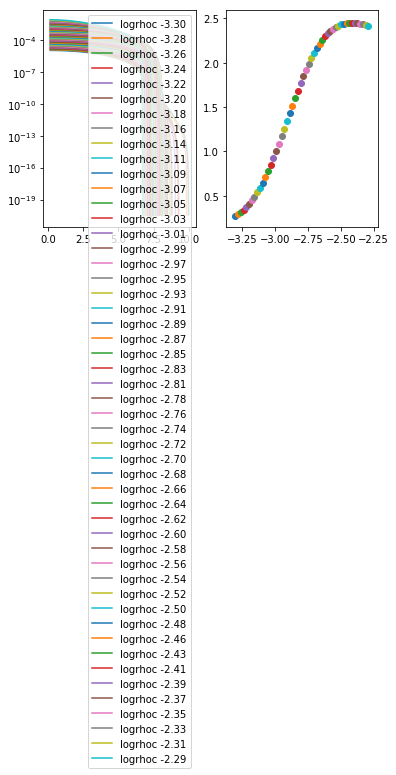

In [95]:
fig,[ax1,ax2] = plt.subplots(1,2)

final_values = []
integrator = 'vode'
Nr = 200


print(test.rho_bounds)
#for logrhoc in np.linspace(-3.3, -2.2903, 30):
for logrhoc in np.linspace(-3.3, -2.2903, 50):
    print(logrhoc)
    star = TableStar(filename)
    star.set_initial_conditions(rhoc = 10**logrhoc)
    solver, t, y = star.old_solve_star(integrator = integrator, Nr = Nr)
    
    last_pos = -1 
    final_values.append([logrhoc, t[last_pos]] + list(y[last_pos]))
#     last_pos = np.sum(solve.y[1] > 0) - 1 # assumes strictly decreasing values. -1 for python indexing
#     final_values.append([logrhoc, solve.t[last_pos]] + list(solve.y[:,last_pos]))
    
    ax1.semilogy(t, y[:, 1], label = 'logrhoc {:.2f}'.format(logrhoc))
    ax2.scatter(logrhoc, y[last_pos, 0])
ax1.legend()
# rhoc = 3e15 * 1.6199e-18
# test = TableStar(filename).set_initial_conditions(rhoc = rhoc)

In [98]:
rho, r_values, m_values, P_values, phi_values, M0_values = np.array(final_values).T
print(star.r_max/100)

0.33853


Text(0,0.5,'Mass [$M_\\odot$]')

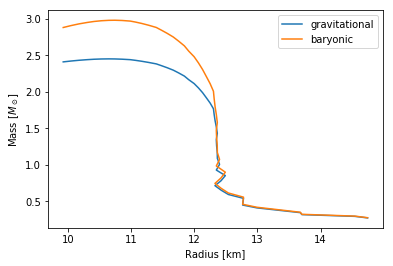

In [99]:
to_km = 1e-5/6.7706e-6

plt.plot(to_km*r_values, m_values, label = 'gravitational')
plt.plot(to_km*r_values, M0_values, label = 'baryonic')
plt.legend()
plt.xlabel('Radius [km]')
plt.ylabel(r'Mass [$M_\odot$]')

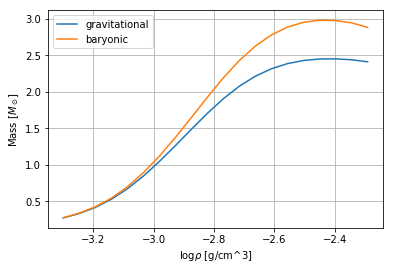

In [37]:
plt.plot(rho, m_values, label = 'gravitational')
plt.plot(rho, M0_values, label = 'baryonic')
plt.legend()
plt.xlabel(r'$\log \rho$ [g/cm^3]')
plt.ylabel(r'Mass [$M_\odot$]')
plt.grid()

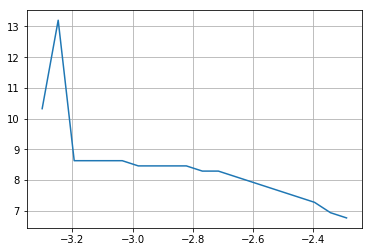

In [38]:
plt.plot(rho, r_values)
plt.grid()

In [ ]:
np.log10(3e15 * 1.6199e-18)

In [ ]:
rho_arr = test.rho_arr
np.min(rho_arr)

In [ ]:
a, b  = test.ye_bounds
print(test.pres_bounds)
print(test.rho_bounds)
test.pres_interp(a, -15), test.pres_interp(b, -13)

In [ ]:
test.ye_bounds

[0.4999995] [0.4999995]


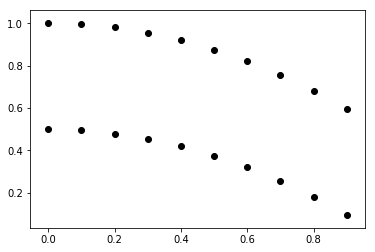

In [86]:
def f(x):
    return -x
from scipy.integrate import ode 

solver = ode(f)

 
prev_t = 0
prev_y = 1
solver.set_initial_value(prev_y,prev_t)
dx = 0.1
for i in range(20):
    if i == 10:
        solver.set_initial_value(prev_y, 0)
        print(solver.y, prev_y)
        
    plt.scatter(solver.t, solver.y, c ='k')
        
    solver.integrate(solver.t + dx)
    prev_t = solver.t
    prev_y = solver.y

In [ ]:
dir(solver)

In [ ]:

test.P(test.rhoc)
[(test.P(v),v) for v in np.logspace(-10,1,11)]

In [ ]:
test.solve_star()

In [ ]:
T_arr = np.array(f['logtemp'])
ye_arr = np.array(f['ye'])
rho_arr = np.array(f['logrho'])

rho_grid, ye_grid = np.meshgrid(rho_arr, ye_arr)
pres_values = f['logpress'][:,0,:]
munu_values = f['munu'][:,0,:]


ye_pres_points = np.column_stack([ye_grid.ravel(), pres_values.ravel()]),
ye_rho_points  = np.column_stack([ye_grid.ravel(), rho_grid.ravel()]),

rho_interp  = LinearNDInterpolator(ye_pres_points, rho_grid.ravel())
pres_interp = LinearNDInterpolator(ye_rho_points, pres_values.ravel())
munu_interp = LinearNDInterpolator(ye_rho_points, munu_values.ravel())

In [ ]:
func3 = lambda ye, P : munu_interp([ye, P])
ye_bounds = [np.min(ye_arr), np.max(ye_arr)]
res = optimize.root_scalar(func3, method = 'brentq', args=(P), bracket = ye_bounds)
res

In [ ]:
? optimize.fsolve

In [ ]:
rho_interp = interp2d(ye_grid, pres_values, rho_grid)

pres_interp = interp2d(ye_grid, rho_grid, pres_values)

In [ ]:
# rho_interp(0.4, 20)
pres_interp([0.4, 0.7], [4, 5])

In [ ]:
?pres_interp

In [ ]:
a = pres_interp(ye_grid.ravel(), pres_values.ravel())

In [ ]:
np.isclose(a, pres_values)

In [ ]:
rho_interp(0.4, 20)

In [ ]:
%timeit rho_interp(0.4, 20)

In [ ]:
rho_shaped = rho_values.reshape(pres_grid.shape)

In [ ]:
valid_cols = ~np.any(np.isnan(rho_values.reshape(pres_grid.shape)), axis = 0)
rho_valid = rho_shaped[:,valid_cols]

plt.imshow(rho_shaped[:,valid_cols])

In [ ]:
grid_reshaped = grid.reshape(list(pres_grid.shape)+[-1])
plt.pcolormesh(grid_reshaped[:,:,0], grid_reshaped[:,:,1], rho_shaped)

In [ ]:
grid_valid = grid_reshaped[:,valid_cols]
m = plt.pcolormesh(grid_valid[:,:,0], grid_valid[:,:,1], rho_valid)
plt.colorbar(m)

In [ ]:
grid_valid = grid_reshaped[:,valid_cols]

In [ ]:
grid_valid.shape, rho_valid.shape

In [ ]:
sdalsadj

In [ ]:
? interp2d

In [ ]:
rho_interp = interp2d(grid_reshaped[:,valid_cols,0].ravel(), 
                           grid_reshaped[:,valid_cols,1].ravel(), 
                           rho_valid.ravel())

In [ ]:
grid.shape
np.any(np.isnan(rho_values))

In [ ]:
pressure_interp(grid.T[0], grid.T[1])

In [ ]:
Nrho, Ntemp, Nye, pres_values.shape

In [ ]:
m = plt.scatter(ye_grid.ravel(), rho_grid.ravel(), c = pres_values.ravel())
plt.colorbar(m)

In [ ]:
m = plt.scatter(grid.T[0], grid.T[1], marker='.', c = rho_values)
plt.colorbar(m)

In [ ]:
from scipy.interpolate import griddata

pressure_grid = np.linspace(np.min(a), np.max(a), N)
P,_b = np.meshgrid(pressure_grid, b)

print(P.shape)
points = np.array([A.ravel(), c.ravel()]).T
values = B.ravel()
xi = np.array([A.ravel(), c.ravel()]).T

print(B.size, c.size, A.size)
print(points.shape)

gd = griddata(points, values, xi) 
plt.pcolormesh(points[:,0], points[:,1], gd)

In [ ]:
np.concatenate([A.ravel(),B.ravel()])

In [ ]:
np.array(f['logrho'])

 
  - Determine the maximum mass for any five of the EOS available on stellarcollapse.org.
 

 
  - Make mass vs. radius plots for these same five EOS.